# Algorithm Implementation: Gradient Descent

## Overview
Implementation of Gradient Descent for optimizing predictions of life expectancy based on development indicators. This algorithm helps us understand how different socio-economic and environmental factors contribute to health outcomes, with a focus on finding the optimal weights for each factor through iterative optimization.

## Objectives
- Predict life expectancy using multiple development indicators
- Optimize the prediction model using gradient descent
- Analyze the impact of different factors on health outcomes
- Understand the trade-offs between development and health

## Key Questions
1. How do economic indicators (GDP, debt) influence life expectancy?
2. What is the relationship between environmental impact (GHG emissions) and health outcomes?
3. How do labor force participation and military expenditure affect life expectancy?

In [12]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
plt.style.use('seaborn-v0_8-white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette(['#1f77b4', '#ff7f0e']) 
%matplotlib inline

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

In [13]:
# Define indicators
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "Total GHG Emissions",
    "SP.POP.TOTL": "Population",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure",
    "DT.TDS.DPPF.XP.ZS": "Debt Service"
}

def fetch_data():
    print("Fetching data from World Bank...")
    data = {}
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
        
    # Convert to DataFrame
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Pivot and process
    df = df.pivot_table(
        index=['country', 'year'],
        columns='indicator',
        values='value'
    ).reset_index()
    
    # Sort and compute derived metrics
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    df["GHG Emissions per Capita"] = (df["Total GHG Emissions"] * 1_000_000) / df["Population"]
    df = df.drop(columns=["Total GHG Emissions", "Population"])
    
    return df

# Fetch the data
df = fetch_data()

Fetching data from World Bank...
Fetching GDP per capita...
Fetching Life Expectancy...
Fetching Total GHG Emissions...
Fetching Population...
Fetching Labor Force Participation...
Fetching Military Expenditure...
Fetching Debt Service...

Processing data...


### 2. Data Preprocessing
We'll clean the data, handle missing values, and prepare it for gradient descent optimization.

In [4]:
def preprocess_data(df):
    # Take most recent year's data for each country
    df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
    
    # Log transform GDP and GHG emissions
    df_recent['GDP per capita (log)'] = np.log(df_recent['GDP per capita'])
    df_recent['GHG Emissions per Capita (log)'] = np.log(df_recent['GHG Emissions per Capita'])
    
    # Handle missing values
    numeric_columns = df_recent.select_dtypes(include=[np.number]).columns
    df_recent[numeric_columns] = df_recent[numeric_columns].fillna(df_recent[numeric_columns].mean())
    
       # Create development categories based on GDP per capita
    df_recent['Development Category'] = pd.qcut(
        df_recent['GDP per capita'],
        q=4,
        labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High']
    )
    
    # Remove outliers using IQR method
    Q1 = df_recent['Life Expectancy'].quantile(0.25)
    Q3 = df_recent['Life Expectancy'].quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df_recent[
        (df_recent['Life Expectancy'] >= Q1 - 1.5 * IQR) &
        (df_recent['Life Expectancy'] <= Q3 + 1.5 * IQR)
    ]
    
    
    return df_clean

# Preprocess the data
df_processed = preprocess_data(df)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed.info())

print("\nSample of processed data:")
print(df_processed.head())


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   country                         268 non-null    object  
 1   year                            268 non-null    int64   
 2   Debt Service                    268 non-null    float64 
 3   GDP per capita                  268 non-null    float64 
 4   Labor Force Participation       268 non-null    float64 
 5   Life Expectancy                 268 non-null    float64 
 6   Military Expenditure            268 non-null    float64 
 7   GHG Emissions per Capita        268 non-null    float64 
 8   GDP per capita (log)            268 non-null    float64 
 9   GHG Emissions per Capita (log)  268 non-null    float64 
 10  Development Category            268 non-null    category
dtypes: category(1), float64(8), int64(1), object(1)
memory usag

## Data Analysis and Visualization

### 1. Exploratory Data Analysis

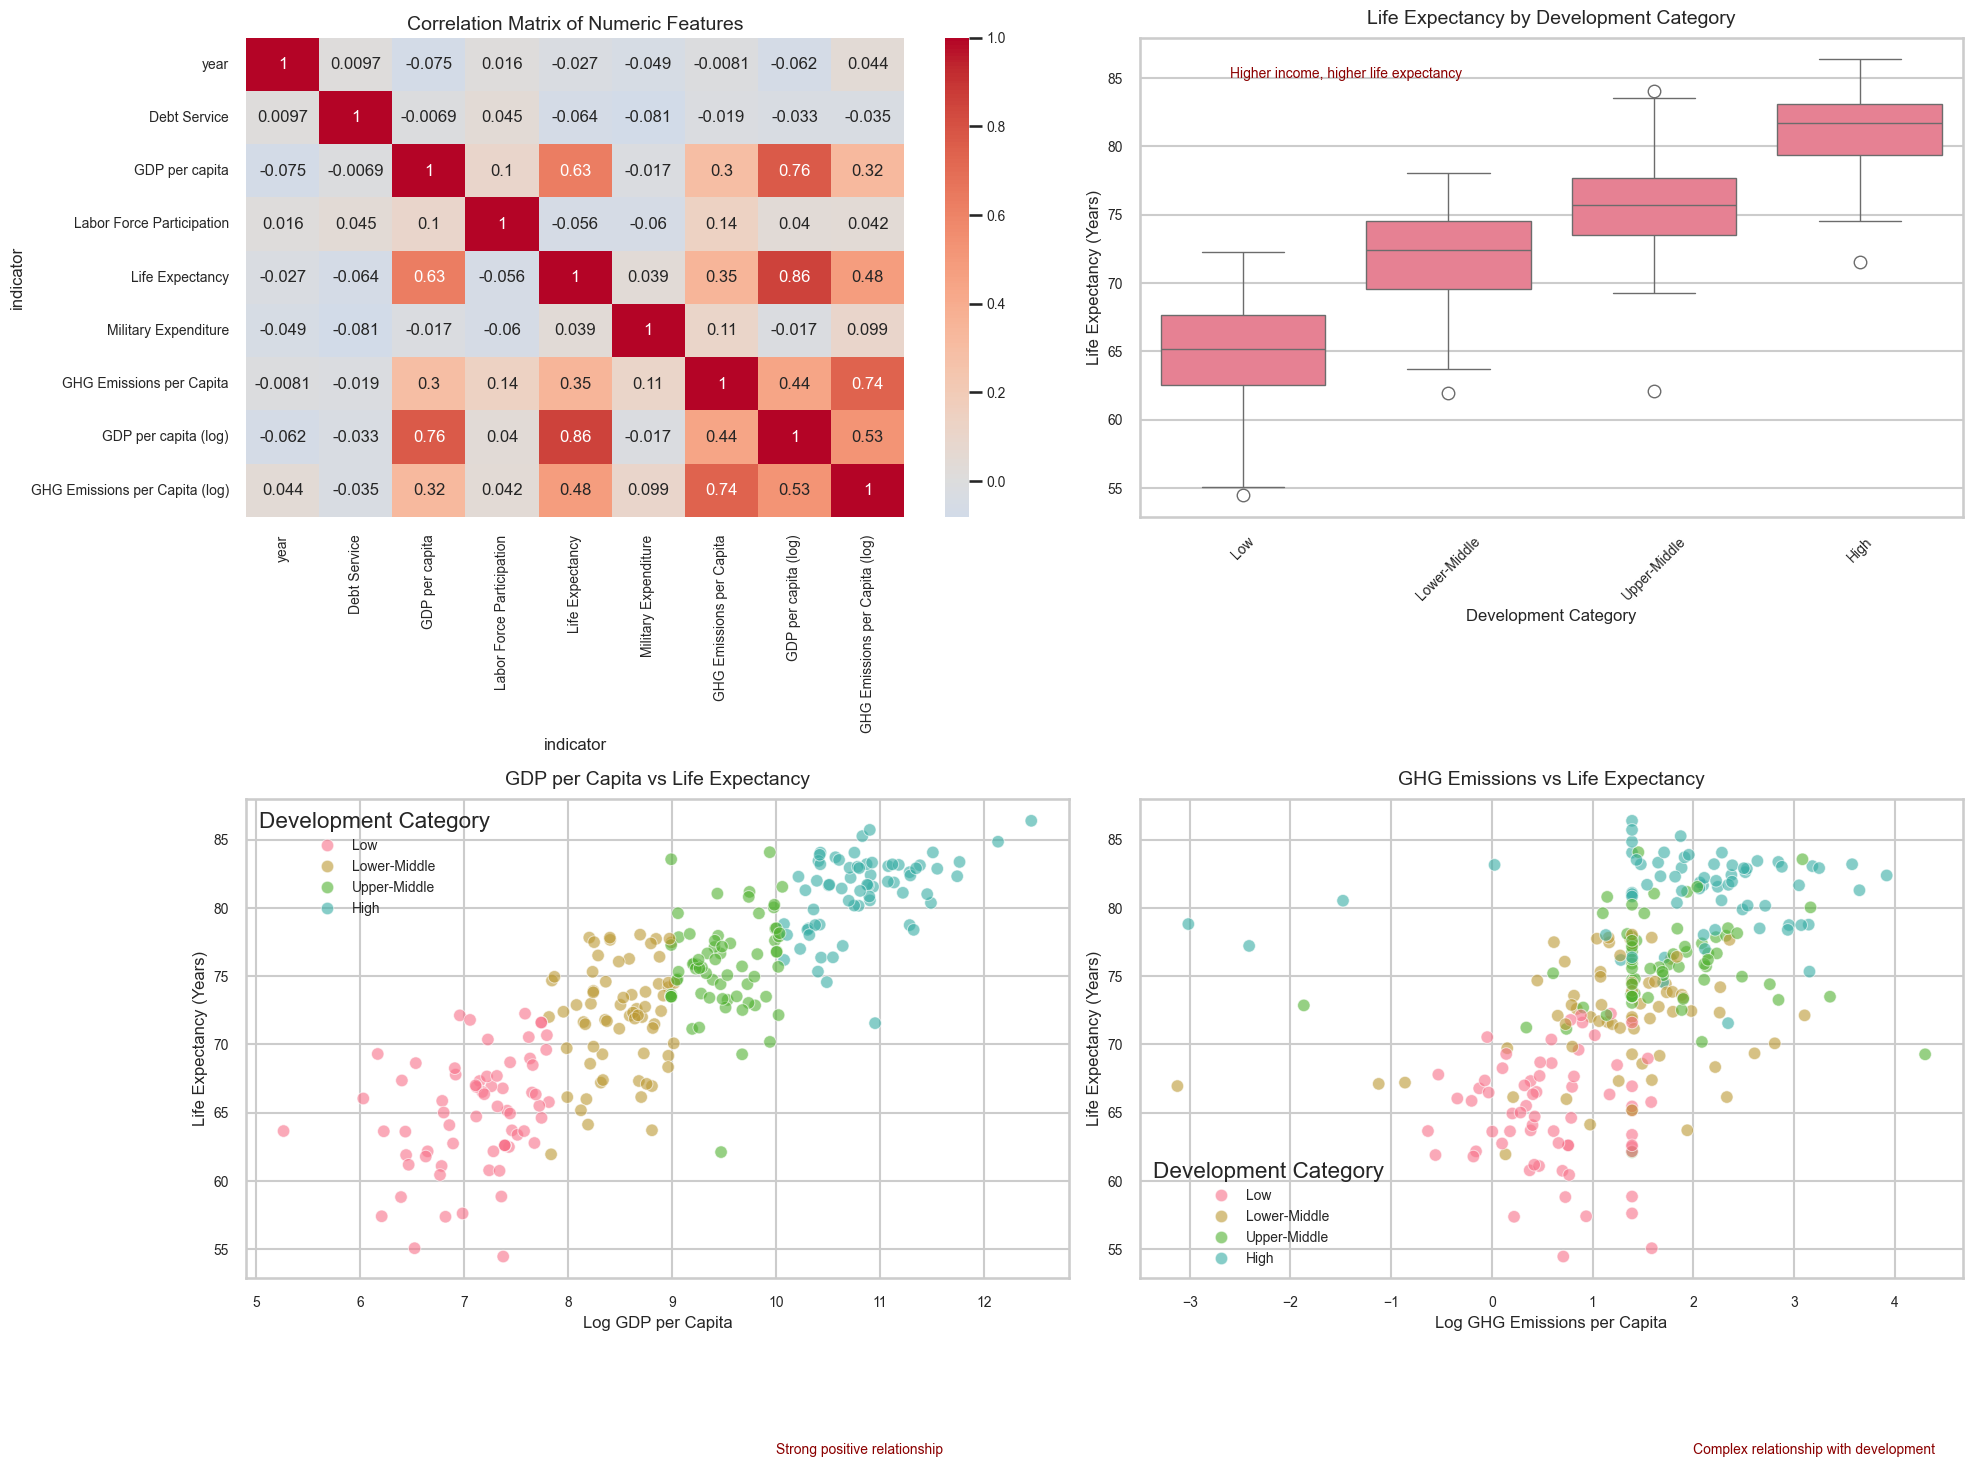

In [5]:

def plot_exploratory_analysis(df):
 
    # Check for required columns
    required_columns = ['country', 'year', 'GDP per capita (log)', 'GHG Emissions per Capita (log)', 
                        'Life Expectancy', 'Development Category']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns in DataFrame: {missing_columns}")
    
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 
                         'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10})
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))  # Adjusted size for three subplots
    
     # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    
    # 1. Life Expectancy Across Development Categories (Overview)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Development Category', y='Life Expectancy')
    plt.title('Life Expectancy by Development Category', pad=10)
    plt.xlabel('Development Category')
    plt.ylabel('Life Expectancy (Years)')
    plt.xticks(rotation=45)
    # Simplified annotation
    plt.text(0.5, 85, 'Higher income, higher life expectancy', ha='center', fontsize=10, color='darkred')
    
    # 2. GDP per Capita vs Life Expectancy (Economic Impact)
    plt.subplot(2, 2, 3)
    sns.scatterplot(
        data=df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        hue='Development Category',
        alpha=0.6
    )
    plt.title('GDP per Capita vs Life Expectancy', pad=10)
    plt.xlabel('Log GDP per Capita')
    plt.ylabel('Life Expectancy (Years)')
    # Simplified legend
    plt.legend(title='Development Category')
    plt.text(10, 40, 'Strong positive relationship', fontsize=10, color='darkred')
    
    # 3. GHG Emissions vs Life Expectancy (Environmental Impact)
    plt.subplot(2, 2, 4)
    sns.scatterplot(
        data=df,
        x='GHG Emissions per Capita (log)',
        y='Life Expectancy',
        hue='Development Category',
        alpha=0.6
    )
    plt.title('GHG Emissions vs Life Expectancy', pad=10)
    plt.xlabel('Log GHG Emissions per Capita')
    plt.ylabel('Life Expectancy (Years)')
    plt.legend(title='Development Category')
    plt.text(2, 40, 'Complex relationship with development', fontsize=10, color='darkred')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Call the function
plot_exploratory_analysis(df_processed)

### Relationships of Labor Force Participation and Military Expenditure with life expectancy

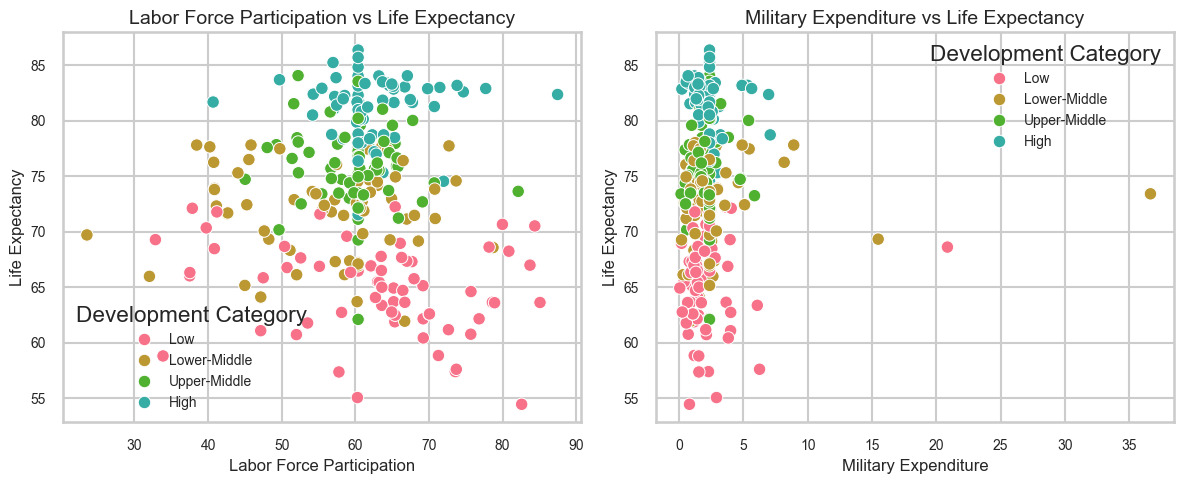

In [6]:
# Scatter plots for Labor Force Participation and Military Expenditure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df_processed, x='Labor Force Participation', y='Life Expectancy', 
                hue='Development Category', ax=axes[0])
axes[0].set_title('Labor Force Participation vs Life Expectancy')

sns.scatterplot(data=df_processed, x='Military Expenditure', y='Life Expectancy', 
                hue='Development Category', ax=axes[1])
axes[1].set_title('Military Expenditure vs Life Expectancy')

plt.tight_layout()
plt.show()

### Life Expectancy vs GHG Emissions across Development Categories

Trade-offs Across Development Categories:
indicator Development Category  Life Expectancy  \
0                          Low        64.929031   
1                 Lower-Middle        72.074152   
2                 Upper-Middle        75.820366   
3                         High        81.140347   

indicator  GHG Emissions per Capita (log)  Debt Service  
0                                0.605030      9.255753  
1                                1.265056      8.266251  
2                                1.712010      8.507311  
3                                1.980970      8.676438  


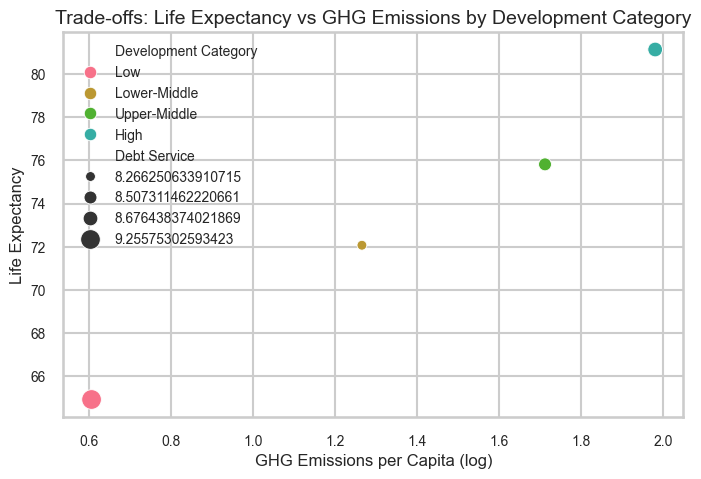

In [7]:
# Analyze trade-offs: Life Expectancy vs GHG Emissions across Development Categories
tradeoffs = df_processed.groupby('Development Category').agg({
    'Life Expectancy': 'mean',
    'GHG Emissions per Capita (log)': 'mean',
    'Debt Service': 'mean'
}).reset_index()
print("Trade-offs Across Development Categories:")
print(tradeoffs)

# Visualize trade-offs
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=tradeoffs, x='GHG Emissions per Capita (log)', y='Life Expectancy', 
                size='Debt Service', hue='Development Category', sizes=(50, 200))
plt.title('Trade-offs: Life Expectancy vs GHG Emissions by Development Category')
plt.show()

## Algorithm Implementation

### 1. Gradient Descent Implementation

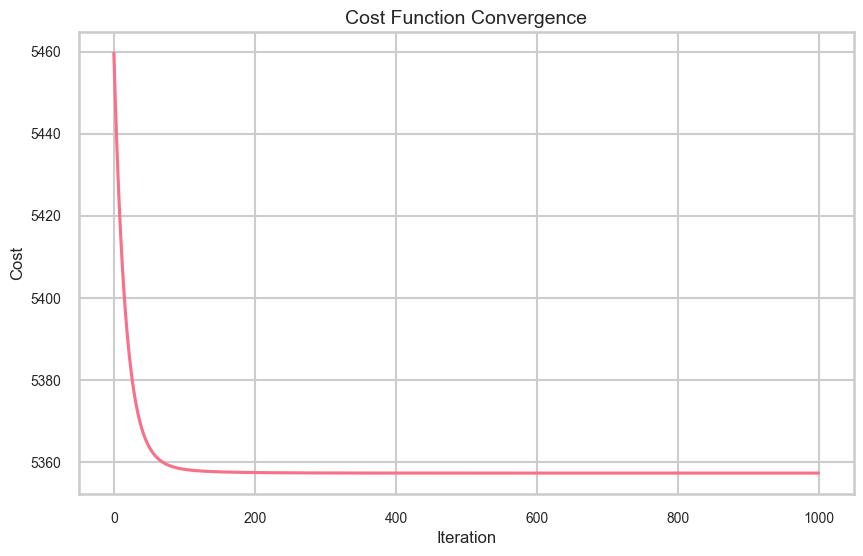


Feature Weights:
GDP per capita (log): 3.7301
GHG Emissions per Capita (log): 7.0555
Labor Force Participation: 2.6188
Military Expenditure: 0.6019
Debt Service: -1.9316


In [8]:
class CustomGradientDescent:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.cost_history = []
        
    def fit(self, X, y):
        # Initialize weights
        self.weights = np.zeros(X.shape[1])
        
        # Gradient descent
        for i in range(self.max_iter):
            # Compute predictions
            y_pred = np.dot(X, self.weights)
            
            # Compute error and cost
            error = y_pred - y
            cost = np.mean(error ** 2)
            self.cost_history.append(cost)
            
            # Compute gradient
            gradient = 2/len(X) * np.dot(X.T, error)
            
            # Update weights
            old_weights = self.weights.copy()
            self.weights -= self.learning_rate * gradient
            
            # Check convergence
            if np.sum(np.abs(self.weights - old_weights)) < self.tol:
                print(f"Converged after {i+1} iterations")
                break
                
        return self
    
    def predict(self, X):
        return np.dot(X, self.weights)

# Prepare data for gradient descent
features = ['GDP per capita (log)', 'GHG Emissions per Capita (log)', 
           'Labor Force Participation', 'Military Expenditure', 'Debt Service']
X = df_processed[features]
y = df_processed['Life Expectancy']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train custom gradient descent
custom_gd = CustomGradientDescent(learning_rate=0.01, max_iter=1000)
custom_gd.fit(X_train, y_train)

# Plot cost history
plt.figure(figsize=(10, 6))
plt.plot(custom_gd.cost_history)
plt.title('Cost Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

# Print feature weights
print("\nFeature Weights:")
for feature, weight in zip(features, custom_gd.weights):
    print(f"{feature}: {weight:.4f}")

### 2. Scikit-learn SGD Implementation

In [9]:
# Create SGD pipeline
sgd_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(
        loss='squared_error',
        learning_rate='adaptive',
        eta0=0.01,
        max_iter=1000,
        tol=1e-6,
        random_state=42
    ))
])

# Fit the pipeline
sgd_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = sgd_pipeline.predict(X_train)
y_pred_test = sgd_pipeline.predict(X_test)

# Print performance metrics
print("Training Performance:")
print(f"R� Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

print("\nTest Performance:")
print(f"R� Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

Training Performance:
R� Score: 0.7917
MSE: 10.1879
MAE: 2.4305

Test Performance:
R� Score: 0.6009
MSE: 16.9906
MAE: 3.1526


## Results and Interpretation

### 1. Model Comparison

Model Comparison:
               Model    R² Score          MSE        MAE
0          Custom GD -137.310941  5887.870959  76.290598
1                SGD    0.600878    16.990560   3.152613
2  Linear Regression    0.679981    13.623153   2.871783


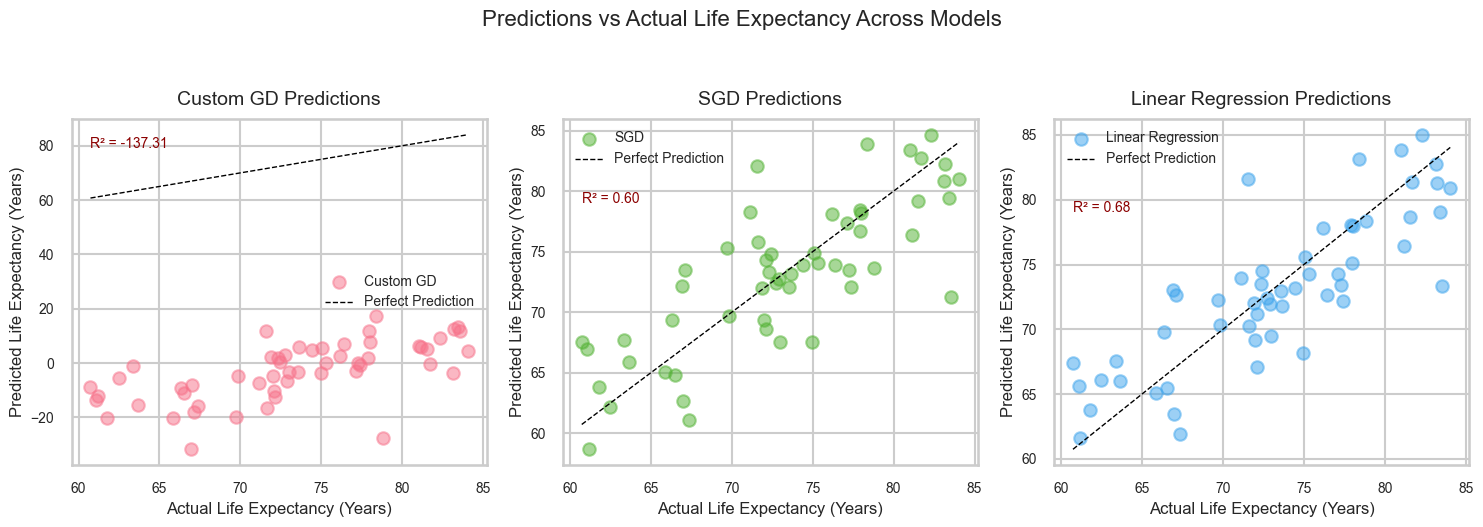

In [10]:
# Compare with Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Create comparison DataFrame
models = {
    'Custom GD': custom_gd.predict(X_test),
    'SGD': y_pred_test,
    'Linear Regression': y_pred_lr
}

# Collect results in a list of dictionaries
results_list = []
for name, predictions in models.items():
    results_list.append({
        'Model': name,
        'R² Score': r2_score(y_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'MAE': mean_absolute_error(y_test, predictions)
    })

# Create DataFrame from the list
results = pd.DataFrame(results_list)

print("Model Comparison:")
print(results)

# Plot predictions vs actual values
fig = plt.figure(figsize=(15, 5))
colors = sns.color_palette("husl", 3)  # One color per model

for i, (name, predictions) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, predictions, alpha=0.5, color=colors[i-1], label=name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'k--', lw=1, label='Perfect Prediction')
    plt.xlabel('Actual Life Expectancy (Years)')
    plt.ylabel('Predicted Life Expectancy (Years)')
    plt.title(f'{name} Predictions', pad=10)
    plt.legend()
    r2 = r2_score(y_test, predictions)
    plt.text(y_test.min(), y_test.max() - 5, f'R² = {r2:.2f}', fontsize=10, color='darkred')

plt.suptitle('Predictions vs Actual Life Expectancy Across Models', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### 2. Feature Importance Analysis - Which Factors Most Influence Life Expectancy?

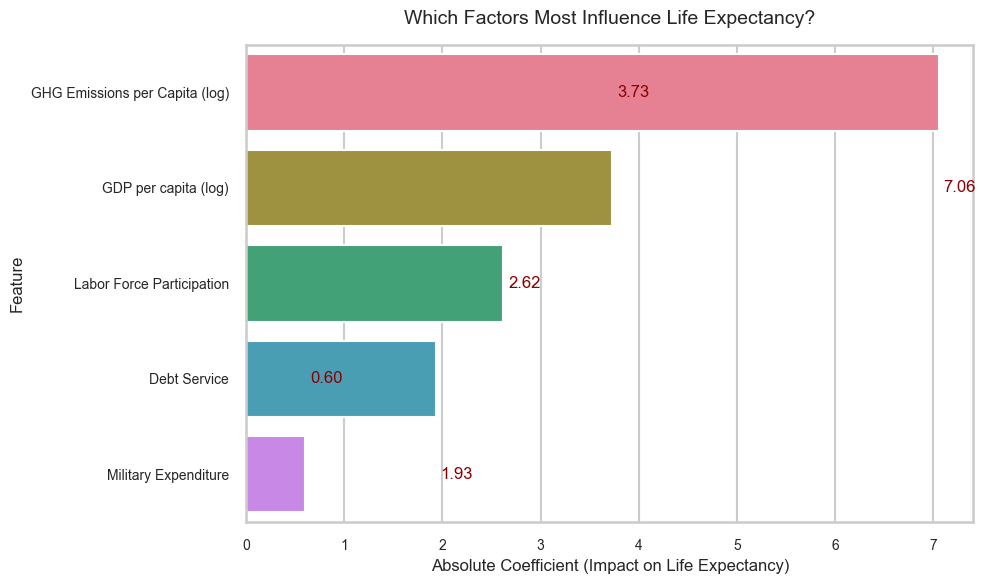


Feature Importance:
                          Feature  Coefficient
1  GHG Emissions per Capita (log)     7.055522
0            GDP per capita (log)     3.730106
2       Labor Force Participation     2.618799
4                    Debt Service     1.931552
3            Military Expenditure     0.601884

Results saved to 'gradient_descent_results.csv'


In [11]:
def analyze_feature_importance(model, feature_names):
    # Get feature coefficients
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        coefficients = model.weights
    
    # Create importance DataFrame
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': np.abs(coefficients)
    })
    importance = importance.sort_values('Coefficient', ascending=False)
    
    # Plot feature importance with enhanced storytelling
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(data=importance, x='Coefficient', y='Feature', palette='husl')
    plt.title('Which Factors Most Influence Life Expectancy?', pad=15, fontsize=14)
    plt.xlabel('Absolute Coefficient (Impact on Life Expectancy)')
    plt.ylabel('Feature')
    
    # Add annotations for top features
    for i, row in importance.iterrows():
        bar_plot.text(row['Coefficient'] + 0.05, i, f'{row["Coefficient"]:.2f}', 
                      va='center', color='darkred')
    
    plt.tight_layout()
    plt.show()
    
    return importance
# Analyze feature importance
importance_df = analyze_feature_importance(custom_gd, features)
print("\nFeature Importance:")
print(importance_df)

# Save results
results.to_csv('gradient_descent_results.csv', index=False)
print("\nResults saved to 'gradient_descent_results.csv'")